# Topic Model
## Read data

In [1]:
import pandas as pd
import numpy as np

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

In [241]:
df = pd.read_csv('./data/processed_data.csv')

In [3]:
df.head()

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category,text
0,27673,2053,24h,i went on a successful date with someone i fel...,i went on a successful date with someone i fel...,True,1,NaN,affection,successful date sympathy connection
1,27674,2,24h,i was happy when my son got 90% marks in his e...,i was happy when my son got 90% marks in his e...,True,1,NaN,affection,son mark examination
2,27675,1936,24h,i went to the gym this morning and did yoga.,i went to the gym this morning and did yoga.,True,1,NaN,exercise,gym morning yoga
3,27676,206,24h,we had a serious talk with some friends of our...,we had a serious talk with some friends of our...,True,2,bonding,bonding,serious talk friend flaky lately understood go...
4,27677,6227,24h,i went with grandchildren to butterfly display...,i went with grandchildren to butterfly display...,True,1,NaN,affection,grandchild butterfly display crohn conservatory


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100535 entries, 0 to 100534
Data columns (total 10 columns):
hmid                     100535 non-null int64
wid                      100535 non-null int64
reflection_period        100535 non-null object
original_hm              100535 non-null object
cleaned_hm               100535 non-null object
modified                 100535 non-null bool
num_sentence             100535 non-null int64
ground_truth_category    14125 non-null object
predicted_category       100535 non-null object
text                     100522 non-null object
dtypes: bool(1), int64(3), object(6)
memory usage: 7.0+ MB


## Vectorization

### CountVectorizer

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

In [242]:
df = df[df['text'].isna() == False]

In [243]:
%%capture
df['text'].dropna(axis=0, how='any', inplace=True)

In [212]:
bow_transformer = CountVectorizer(analyzer='word').fit(df['text'])

# Print total number of vocab words
print(len(bow_transformer.vocabulary_))

24652


In [213]:
df_bow = bow_transformer.transform(df['text'])

In [11]:
print('Shape of Sparse Matrix: ', df_bow.shape)
print('Amount of Non-Zero occurences: ', df_bow.nnz)

Shape of Sparse Matrix:  (100522, 24652)
Amount of Non-Zero occurences:  716074


In [12]:
# check text sparsicity
sparsity = (100.0 * df_bow.nnz / (df_bow.shape[0] * df_bow.shape[1]))
print('sparsity: {}'.format(round(sparsity)))

sparsity: 0


## LDA

In [7]:
from sklearn.decomposition import LatentDirichletAllocation

### Fit LDA model with 10 topics

In [89]:
lda = LatentDirichletAllocation(n_components=10, 
                                max_iter=50,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0,
                                n_jobs=1)

In [90]:
%%time
lda.fit(df_bow)

CPU times: user 16min 45s, sys: 8.67 s, total: 16min 53s
Wall time: 18min


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=50.0,
                          max_doc_update_iter=100, max_iter=50,
                          mean_change_tol=0.001, n_components=10, n_jobs=1,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [91]:
# Show top n keywords for each topic
def show_topics(vectorizer, lda_model, n_words):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

In [92]:
topic_keywords = show_topics(vectorizer=bow_transformer, lda_model=lda, n_words=10)

In [93]:
# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,daughter,job,watched,mother,movie,surprise,card,want,said,lost
Topic 1,life,dog,make,thing,feel,one,car,get,would,much
Topic 2,family,birthday,husband,morning,work,told,mom,money,party,class
Topic 3,dinner,night,good,girlfriend,food,wife,ate,watching,nice,show
Topic 4,found,getting,finished,finally,gift,free,project,brother,completed,helped
Topic 5,time,first,sister,great,baby,spend,early,park,new,phone
Topic 6,ive,wanted,cat,shopping,summer,date,weather,purchased,great,actually
Topic 7,new,home,work,time,bought,friend,long,see,house,visit
Topic 8,received,old,school,work,parent,vacation,working,song,state,goal
Topic 9,friend,game,new,best,started,lunch,weekend,event,son,played


- Some topics are similar to each other. Try to grid search the best number of topics.

### Grid search the best number of topics

In [94]:
from sklearn.model_selection import GridSearchCV

In [95]:
search_params = {'n_components': [5, 6, 7, 8, 9]}
lda = LatentDirichletAllocation(max_iter=10,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

In [96]:
model = GridSearchCV(lda, param_grid=search_params, cv=3)

In [97]:
%%time
model.fit(df_bow)

CPU times: user 36min 27s, sys: 19.8 s, total: 36min 46s
Wall time: 38min 42s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='online',
                                                 learning_offset=50.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1, random_state=0,
                                                 topic_word_prior=None,
                                                 total_samples=1000000.0,
                 

In [98]:
# Best Model
best_lda_model = model.best_estimator_

In [99]:
print("Best Model's Params: ", model.best_params_)
print('\n')
print("Best Log Likelihood Score: ", model.best_score_)
print('\n')
print("Model Perplexity: ", best_lda_model.perplexity(df_bow))

Best Model's Params:  {'n_components': 5}


Best Log Likelihood Score:  -2066556.0373598626


Model Perplexity:  2413.4145621385214


In [100]:
# Get Log Likelihoods from Grid Search Output
n_topics = [5, 6, 7, 8, 9]
log_likelihoods = model.cv_results_['mean_test_score']

Text(0, 0.5, 'Log Likelihood Scores')

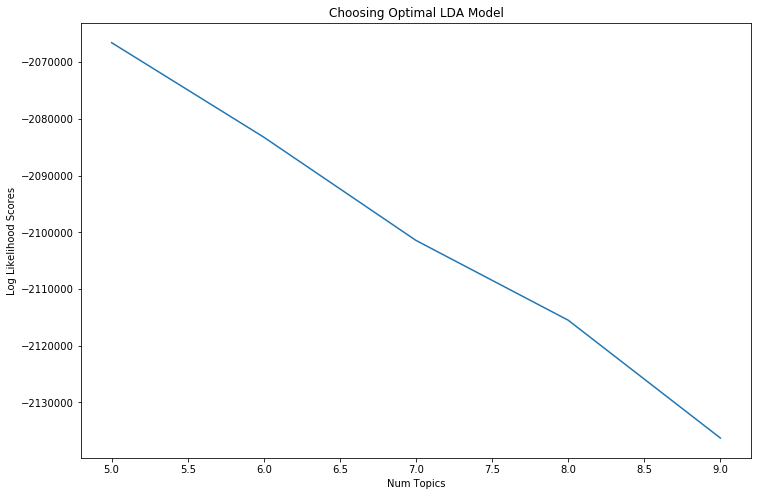

In [101]:
# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelihoods)
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelihood Scores")

### Topic words for best model

In [191]:
topic_keywords = show_topics(vectorizer=bow_transformer, lda_model=best_lda_model, n_words=10)

In [192]:
# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i+1) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 1,found,daughter,finally,new,house,mother,time,finished,game,first
Topic 2,work,job,life,event,good,get,one,feel,make,money
Topic 3,new,bought,wife,morning,husband,home,car,work,nice,told
Topic 4,friend,time,family,dinner,old,birthday,night,good,see,girlfriend
Topic 5,dog,watched,mom,parent,walk,team,completed,park,game,summer


- Topic 1 has words expressing the feeling of a monment, so I define it as enjoy the moment.   
- Topic 2 turns out to be things concerning achievement. 
- Topic 3 can be classified as leisure.  
- Topic 4 involves words like birthday, dinner and famliy which can be concluded as bonding. 
- Topic 5 seems to be related to the affection.     

### Visualize the LDA model

In [252]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(best_lda_model, df_bow, bow_transformer)

/Users/wangxinquan/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.114933  0.036354       1        1  27.022499
3      0.035775 -0.292630       2        1  24.518414
0      0.088986  0.277971       3        1  17.518358
2      0.136799 -0.051848       4        1  17.381549
4     -0.376492  0.030152       5        1  13.559179, topic_info=      Category          Freq       Term         Total  loglift  logprob
8450   Default  10078.000000     friend  10078.000000  30.0000  30.0000
14539  Default   8807.000000        new   8807.000000  29.0000  29.0000
24265  Default   7851.000000       work   7851.000000  28.0000  28.0000
8326   Default   3652.000000      found   3652.000000  27.0000  27.0000
7595   Default   4375.000000     family   4375.000000  26.0000  26.0000
...        ...           ...        ...           ...      ...      ...
1857    Topic5    528.033662  beautiful    960.537074   1.3998  -5.2673
19161   Topic5    669.001582        see   3153.298301   0.4477  -5.0307
20229   Topic5    638.614336        son   3493.371324   0.2988  -5.0772
9279    Topic5    623.016942      great   3354.788138   0.3145  -5.1019
7969    Topic5    630.300620      first   4413.339915   0.0519  -5.0903

[245 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
89         3  0.997145   accepted
385        4  0.999296  afternoon
672        5  0.998520    amazing
860        1  0.816362    another
860        2  0.043615    another
...      ...       ...        ...
24291      1  0.243973    working
24291      3  0.751407    working
24291      4  0.004331    working
24348      1  0.999661      would
24455      5  0.998055       yard

[293 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 1, 3, 5])

Although there's overlap between the blobs, this topic model is fairly good to identify different topics. And topic enjoy the moment and affection are separated distinctly from the other topics.

### Get dominant topic for each document

In [233]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(df_bow)

# column names
topicnames = ["Topic" + str(i) for i in range(5)]

# index names
docnames = ["Doc" + str(i) for i in range(len(df))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

In [223]:
df_document_topic.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.04,0.04,0.04,0.04,0.84,4
Doc1,0.05,0.05,0.05,0.05,0.80,4
Doc2,0.05,0.05,0.80,0.05,0.05,2
Doc3,0.55,0.02,0.02,0.39,0.02,0
Doc4,0.87,0.03,0.03,0.03,0.03,0


In [234]:
mapping = {0:'enjoy_the_moment', 1:'achievement', 2:'leisure', 3:'bonding', 4:'affection'}

In [235]:
df_document_topic['dominant_topic'] = df_document_topic['dominant_topic'].map(mapping)

In [236]:
df_document_topic.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.04,0.04,0.04,0.04,0.84,affection
Doc1,0.05,0.05,0.05,0.05,0.80,affection
Doc2,0.05,0.05,0.80,0.05,0.05,leisure
Doc3,0.55,0.02,0.02,0.39,0.02,enjoy_the_moment
Doc4,0.87,0.03,0.03,0.03,0.03,enjoy_the_moment


In [237]:
df.reset_index(drop=True, inplace=True)
df_document_topic.reset_index(drop=True, inplace=True)

In [247]:
df = pd.concat([df, df_document_topic['dominant_topic']], axis=1)

In [249]:
df = df.rename(columns={'dominant_topic': 'Topic'})

In [250]:
df.head()

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,text,Topic
0,27673.0,2053.0,24h,i went on a successful date with someone i fel...,i went on a successful date with someone i fel...,True,1.0,NaN,successful date sympathy connection,affection
1,27674.0,2.0,24h,i was happy when my son got 90% marks in his e...,i was happy when my son got 90% marks in his e...,True,1.0,NaN,son mark examination,affection
2,27675.0,1936.0,24h,i went to the gym this morning and did yoga.,i went to the gym this morning and did yoga.,True,1.0,NaN,gym morning yoga,leisure
3,27676.0,206.0,24h,we had a serious talk with some friends of our...,we had a serious talk with some friends of our...,True,2.0,bonding,serious talk friend flaky lately understood go...,enjoy_the_moment
4,27677.0,6227.0,24h,i went with grandchildren to butterfly display...,i went with grandchildren to butterfly display...,True,1.0,NaN,grandchild butterfly display crohn conservatory,enjoy_the_moment


### Topics distribution across documents

In [251]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,bonding,30637
1,achievement,25026
2,enjoy_the_moment,18532
3,leisure,16979
4,affection,9348


## Save data with topic 

In [ ]:
df.to_csv(r'./data/topic_data.csv', index=False)